In [1]:
#Step 1: Import the necassary Libraries
import os
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
#Step 2: Data Setup
#Your model wants to read the data, you need to tell it where it is !
train_data_dir = 'train_data'
test_data_dir = 'test_data'
validation_data_dir = 'validation_data'


In [3]:
#Step 3: Set constants
img_size = (224, 224)    #This is for VGG16 to understand it / NO NOT NECASSARY ! The smaller your image size the faster your computational speed !
batch_size = 16          #This is how many images it trains per iteration

In [4]:
#Step 4: Data Augmentation FOR TRAINING
#Since we have little data, we want to augment them by either flipping, rotating, or changing angle ! FOR TRAINING
img_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [5]:
# Use flow_from_directory with subset parameter for training and validation
train_generator = img_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
)





Found 1608 images belonging to 2 classes.


In [6]:
validation_generator = img_datagen.flow_from_directory(
    validation_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
)


Found 130 images belonging to 2 classes.


In [7]:
# Load testing data manually
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Set shuffle to False for evaluation metrics
)

Found 130 images belonging to 2 classes.


In [8]:
#Step 5: Loading the VGG16
# Load VGG16 model with pre-trained weights (include_top=False removes the top layer)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))


In [9]:
#Step 6: # Freeze the convolutional layers
#What this does is freezes your weights from being updated during training
#Its common for transfer learning because it could reduce training time/Mitigate overfitting/preserve pre-trained features
for layer in base_model.layers:
    layer.trainable = False


In [10]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
# Build your own model on top of the frozen model
#In summary, this code constructs a sequential model by adding the frozen VGG16 base model as a feature extractor and then appending
#custom layers for fine-tuning and adapting the model to a specific binary classification task. The dense layers are responsible for
#learning task-specific patterns and making the final predictions.
from keras import regularizers

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))  # Assuming binary classification


In [12]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [13]:
import time
from keras.callbacks import ModelCheckpoint

# Define the ModelCheckpoint callback to save the best weights
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min")

# Record the start time
start_time = time.time()

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

# Record the end time
end_time = time.time()

# Load the best weights before evaluation
model.load_weights("best_model.h5")

# Calculate and print the training time in minutes
training_time_seconds = end_time - start_time
training_time_minutes = training_time_seconds / 60
print(f"Training time: {training_time_minutes:.2f} minutes")

Epoch 1/25
101/101 [==============================] - ETA: 0s - loss: 1.9688 - accuracy: 0.6934

c:\Users\awadm\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


101/101 [==============================] - 295s 3s/step - loss: 1.9688 - accuracy: 0.6934 - val_loss: 1.5831 - val_accuracy: 0.6385
Epoch 2/25
101/101 [==============================] - 285s 3s/step - loss: 1.2427 - accuracy: 0.7985 - val_loss: 1.5661 - val_accuracy: 0.6154
Epoch 3/25
101/101 [==============================] - 276s 3s/step - loss: 1.0241 - accuracy: 0.8346 - val_loss: 1.2632 - val_accuracy: 0.7154
Epoch 4/25
101/101 [==============================] - 278s 3s/step - loss: 0.8971 - accuracy: 0.8675 - val_loss: 1.2348 - val_accuracy: 0.7308
Epoch 5/25
101/101 [==============================] - 275s 3s/step - loss: 0.7977 - accuracy: 0.8787 - val_loss: 1.3763 - val_accuracy: 0.6077
Epoch 6/25
101/101 [==============================] - 273s 3s/step - loss: 0.6877 - accuracy: 0.9123 - val_loss: 1.6440 - val_accuracy: 0.5846
Epoch 7/25
101/101 [==============================] - 282s 3s/step - loss: 0.6621 - accuracy: 0.9005 - val_loss: 1.0890 - val_accuracy: 0.7077
Epoch 8/25

In [14]:
# Evaluate on the test set
test_results = model.evaluate(test_generator)
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])


9/9 [==============================] - 20s 2s/step - loss: 0.7143 - accuracy: 0.7846
Test Loss: 0.7142565250396729
Test Accuracy: 0.7846153974533081


In [15]:
# Predictions on the test set
test_predictions = model.predict(test_generator)
test_labels = test_generator.classes


9/9 [==============================] - 19s 2s/step


In [16]:
# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, np.round(test_predictions), target_names=['cancerous','normal']))



Classification Report:
              precision    recall  f1-score   support

   cancerous       0.79      0.77      0.78        65
      normal       0.78      0.80      0.79        65

    accuracy                           0.78       130
   macro avg       0.78      0.78      0.78       130
weighted avg       0.78      0.78      0.78       130



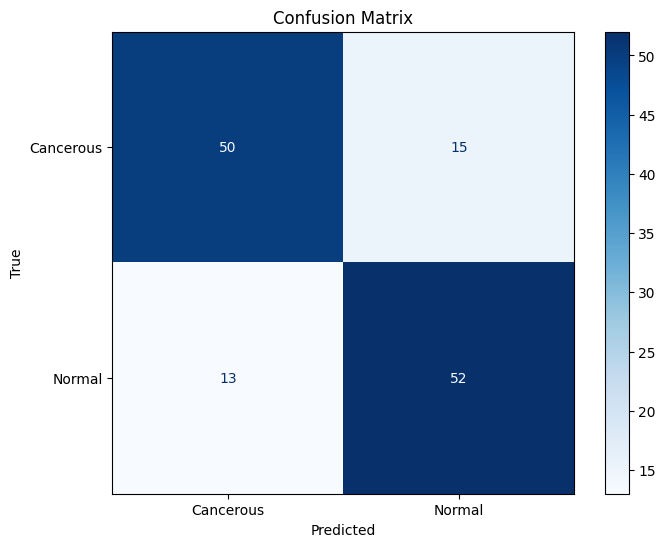

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming test_labels and test_predictions are your true labels and predicted labels, respectively
conf_matrix = confusion_matrix(test_labels, np.round(test_predictions))

# Plot the confusion matrix as a figure using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Cancerous', 'Normal'])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

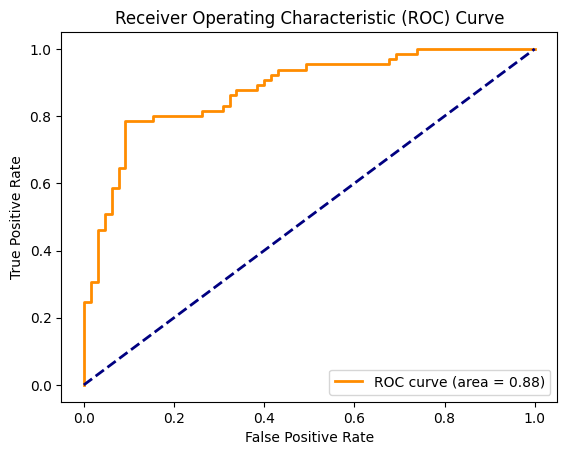

In [18]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(test_labels, test_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [19]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))


<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

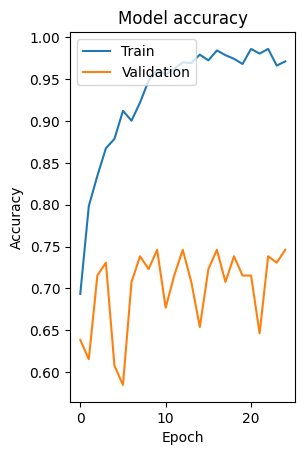

In [20]:
# Plot Training & Validation Accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')


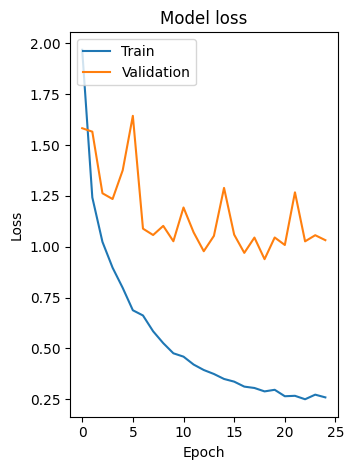

In [21]:
# Plot Training & Validation Loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [26]:
print(test_predictions)
test_generator.labels

[[0.40126956]
 [0.10856885]
 [0.30261666]
 [0.01574758]
 [0.3869033 ]
 [0.04596864]
 [0.44617182]
 [0.07470143]
 [0.19822271]
 [0.3039534 ]
 [0.3125728 ]
 [0.46186253]
 [0.15927957]
 [0.40718427]
 [0.638325  ]
 [0.67695063]
 [0.15451299]
 [0.22060554]
 [0.51352805]
 [0.14357397]
 [0.14793265]
 [0.02713817]
 [0.43363157]
 [0.32597446]
 [0.44867933]
 [0.1138995 ]
 [0.05289927]
 [0.12541214]
 [0.44893822]
 [0.04710993]
 [0.29749772]
 [0.11325652]
 [0.01615371]
 [0.09458595]
 [0.05845544]
 [0.96258855]
 [0.02582831]
 [0.05233368]
 [0.08905714]
 [0.21109995]
 [0.20119876]
 [0.06871779]
 [0.21499838]
 [0.7701233 ]
 [0.3196208 ]
 [0.93428195]
 [0.03075543]
 [0.5715273 ]
 [0.6457781 ]
 [0.9036564 ]
 [0.53733623]
 [0.2572644 ]
 [0.47518864]
 [0.3601944 ]
 [0.7323373 ]
 [0.7432465 ]
 [0.57139075]
 [0.37904412]
 [0.40872326]
 [0.56570464]
 [0.9704944 ]
 [0.21257785]
 [0.97849566]
 [0.9200441 ]
 [0.27873084]
 [0.7845576 ]
 [0.55069894]
 [0.6009073 ]
 [0.84649944]
 [0.8289267 ]
 [0.6243939 ]
 [0.92

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])